<hr style="height:4px;border-width:0;color:black;background-color:green">

## Inference of Covid-19 Vaccines Effectiveness and Uncertainty Using Bayesian Methods
<hr style="height:4px;border-width:0;color:black;background-color:green">

#### Roya Joulaei Vijouyeh
#### Emerson Vero



### Introduction

Several Covid-19 Vaccines have been authorized by the European Medicines Agency (EMA):
• Nuvaxovid (Novavax CZ) [1];
• Vaxzevria (AstraZeneca AB) [2];
• Spikevax (Moderna Biotech) [3]
• Comirnaty (BioNTech/Pfizer) [4]
• Jcovden (Janssen-Cilag) [5]
Similar information is provided in the United States Food and Drugs web site [6]

collect official data available on the  clinical trial performed for each vaccine and compute
with JAGS or Stan the efficacy of each Vaccine. Infere the the 95% credibility interval.

### Goal:

1. collect official data available on the clinical trial performed for each vaccine and compute with JAGS the efficacy of each Vaccine and the the 95% credibility interval.



2. Study on vaccine effficacy according to the age.

 ### Collecting data
 At first we will do all steps for one of the vaccines and then we will do same computatuion for all vaccine which mentioned.
 
Data for Nuvaxovid (Novavax CZ) :

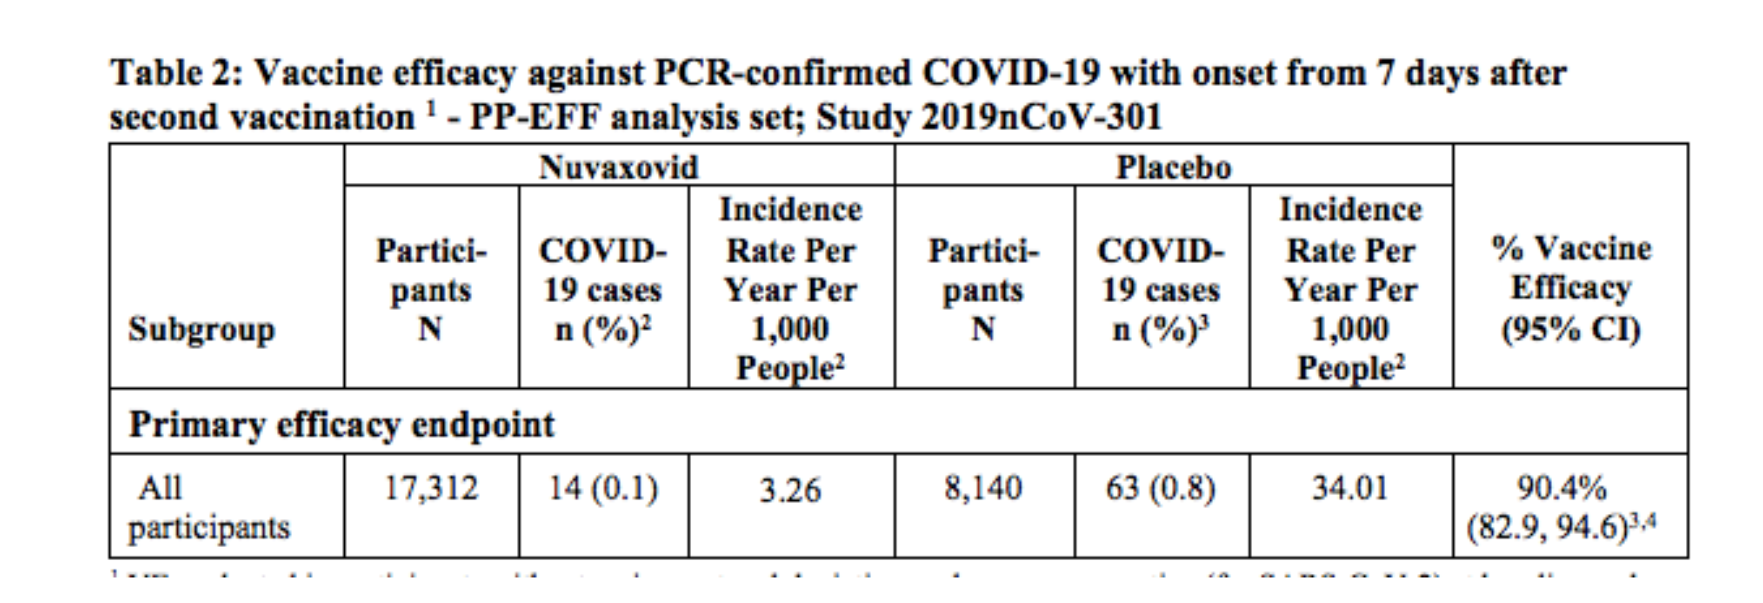

In clinical trails there are two Subgroup:
* Participants who got the vaccine
* Participants who got placebo

* Placebo: 

A placebo is an inactive substance that looks like the drug or treatment being tested. Comparing results from the two groups suggests whether changes in the test group result from the treatment or occur by chance.

* nV:  &emsp;  number people in vaccine gp


* nP:  &emsp;   number people in placebo gp


* pA:  &emsp;  probability to get infected


* nP.I: &emsp; number of people in placebo gp who got Infected


* nV.I: &emsp; number of people in vaccine gp who got Infected



* prob:&emsp; probability to get infected while you are vaccinated


* epsilon:&emsp;efficacy of vaccine = 1 - prob

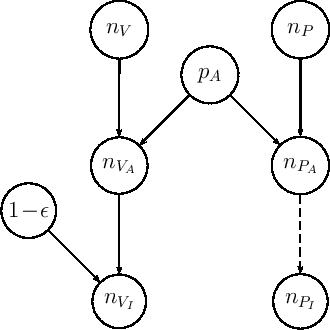

In [119]:
# Install JAGS
system("apt-get install -y jags")

# Install rjags package
install.packages("rjags")

# Load rjags package
library(rjags)



Warning message in system("apt-get install -y jags"):
"'apt-get' not found"


[1] 127

Warning message:
"package 'rjags' is in use and will not be installed"


In [120]:
install.packages("HDInterval")

Warning message:
"package 'HDInterval' is in use and will not be installed"


In [121]:
library(HDInterval)
library(coda)
library(tibble)

In [122]:
nr = 100000          #number of iterations that will be used for sampling from the model


modelinho = "tmp_model.bug"               #create bug language file and write on it
write("
model {
  nV.A  ~ dbin(pA, nV)     #this amount would have gotten covid if there wasn't the vaccine
  nP.I   ~ dbin(pA, nP)    #this amount also, and there wasn't in fact, because they got placebo
  pA ~ dbeta(0.0101010,1)  #we assume a 1% chance of contamination, with relatively weak prior beliefs         #prior
  nV.I ~ dbin(ffe, nV.A)   #the efficacy of the vaccine filters the people who would have gotten covid
  ffe ~ dbeta(1,1)         #ffe is the shield parameter
  eff <- 1 - ffe           #ffe is defined as 1 minus the efficacy                                             #prior
}
", modelinho)     #write bugs model in the file you have just created

#BUGS stands for Bayesian inference Using Gibbling Sampling. It is a framewrok created for bayesian analysis and inference.
#In a BUGS file, you define the structure of the model, specify the observed data and their distributions,
#define the prior distributions for the unknown variables, and describe the relationships between variables.
#The model code in the BUGS file is not directly executed in R. Instead, it is passed to a separate software called JAGS (Just Another Gibbs Sampler),
#which performs the Bayesian inference using Markov Chain Monte Carlo (MCMC) sampling algorithms, such as Gibbs sampling.

# For Pfizer vaccine

In [123]:
# Observed Data For the Model
nP   = 21728     # number of people in the placebo group
nV   = 21720     # number of people in the vaccine group
nP.I = 162       # number of people infected in the placebo group
nV.I = 8         # number of people infected in the vaccine group

data <- list(nP=nP, nV=nV, nP.I=nP.I, nV.I=nV.I)

In [124]:
jm <- jags.model(modelinho, data)     #feeding jags with the model and the data, jags model initializes
update(jm, 100)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model



In [125]:
to.monitor <-  c('pA', 'eff', 'nV.A')      #telling it which variables we want to monitor

In [126]:
chain <- coda.samples(jm, to.monitor, n.iter=nr)   #output is a mcmc object

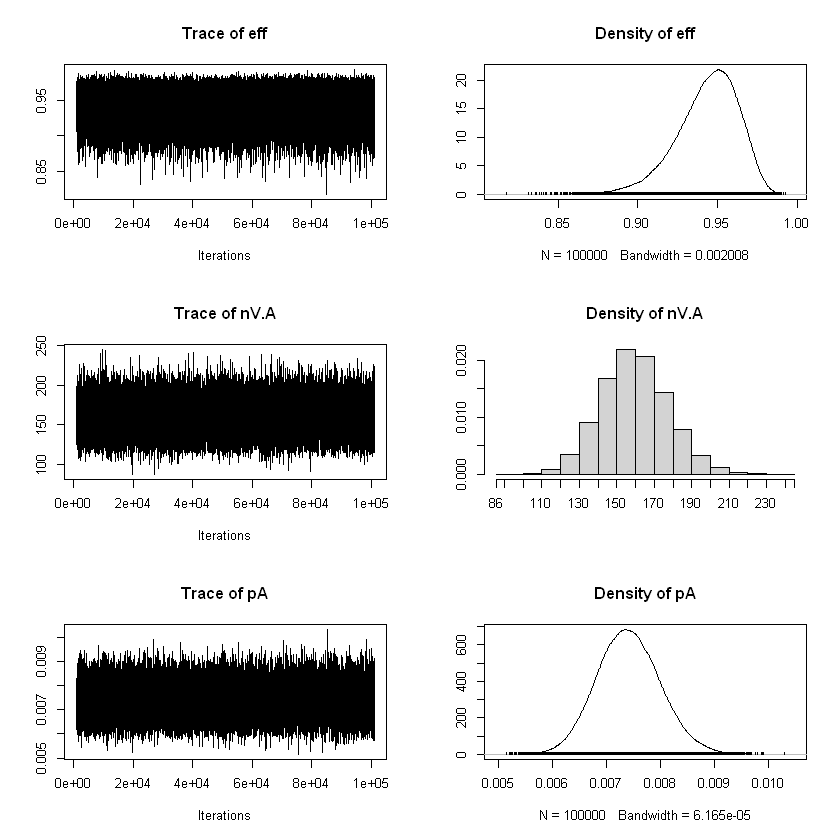

In [127]:
plot(chain)

In [128]:
autocorr.diag(chain)    #Autocorrelation measures the correlation between consecutive samples in the MCMC chain.
#Low autocorrelation values suggest that samples are less dependent on previous samples,
#indicating better mixing and convergence of the chain. Ideally, you want the autocorrelation values to decrease quickly as the lag increases.

,eff,nV.A,pA
Lag 0,1.000000000,1.000000000,1.000000000
Lag 1,0.110021149,0.529491825,0.623417151
Lag 5,0.017045604,0.085521716,0.105478118
Lag 10,0.007482657,0.011797620,0.012238498
Lag 50,0.002284069,0.004368132,0.007029575


In [129]:
chain.df.Pfizer <- as.data.frame( as.mcmc(chain) )            #as.mcmc(chain) converts the object in a mcmc object from the coda package

mean:  0.943780740625039

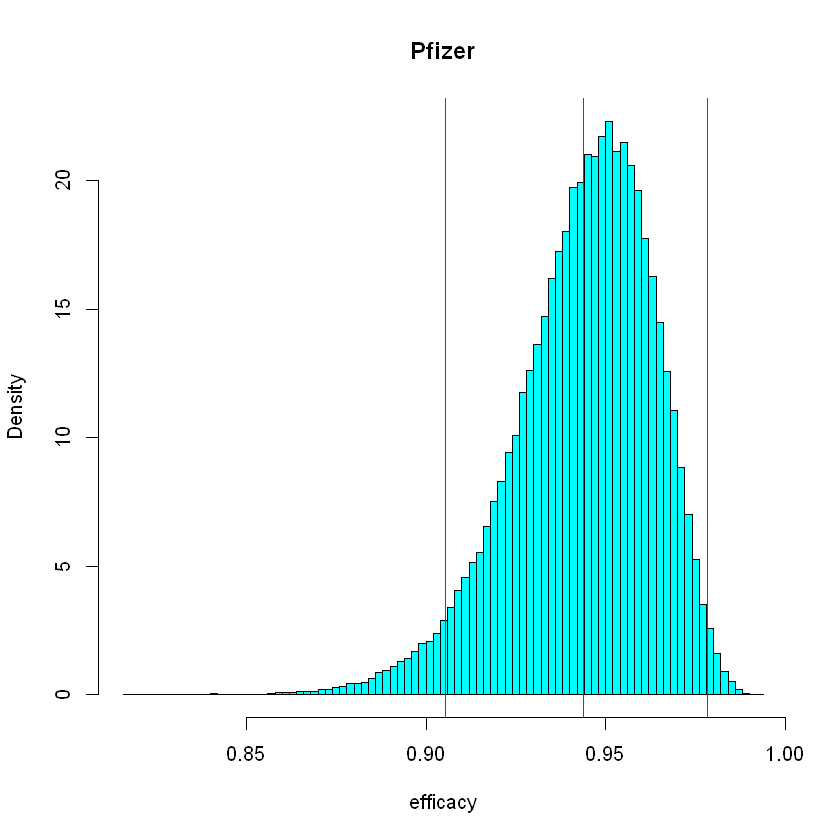

In [130]:
# Extract the efficacy samples from the chain
eff_samples <- chain.df.Pfizer$eff

# Calculate the 95% credibility interval using the HDI function
hdi <- hdi(eff_samples, credMass = 0.95)

cat(paste("mean: ", mean(chain.df.Pfizer$eff)))

hist(chain.df.Pfizer$eff, nc = 100, col = 'cyan', freq = FALSE,
     xlab = 'efficacy', main = 'Pfizer')

horizontal <- c(hdi[1], mean(chain.df.Pfizer$eff), hdi[2])
abline(v = horizontal, col = "red")


95% Interval of Confidence: [ 0.006281901 ,  0.008562641 ]
mean:  0.00741135023427093

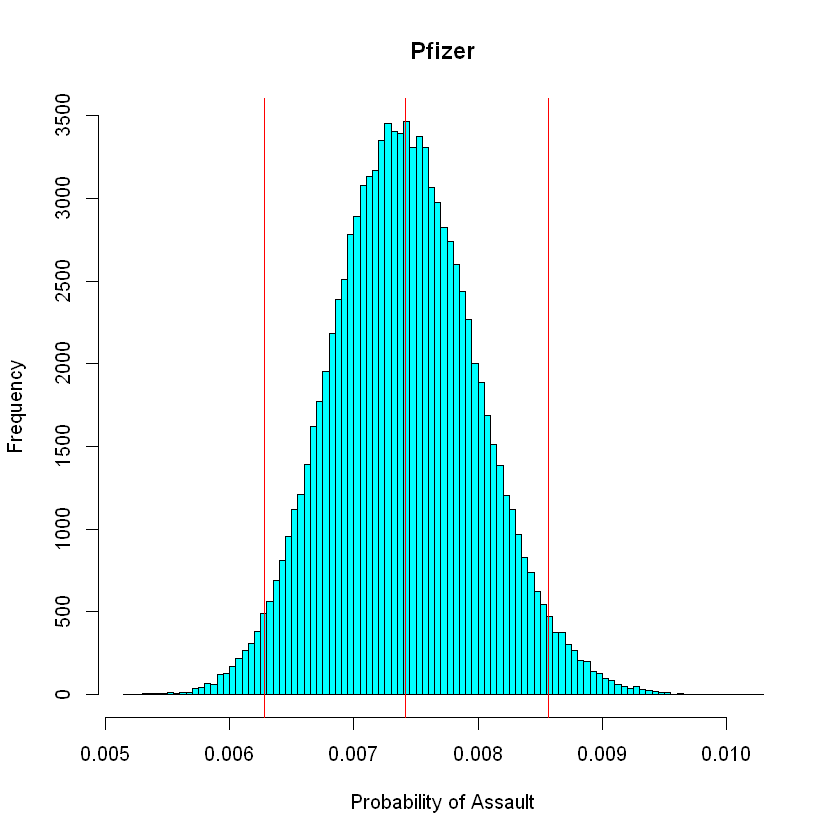

In [131]:
# Extract the efficacy samples from the chain
pA_samples <- chain.df.Pfizer$pA

# Calculate the 95% credibility interval using the quantile function
hdi <- hdi(pA_samples, credMass = 0.95)

# Print the HDI
cat("95% Interval of Confidence: [", hdi[1], ", ", hdi[2], "]\n")

cat(paste("mean: ", mean(chain.df.Pfizer$pA)))

hist(chain.df.Pfizer$pA, nc = 100, col = 'cyan', freq = TRUE,
     xlab = 'Probability of Assault', main = 'Pfizer')

horizontal <- c(hdi[1], mean(chain.df.Pfizer$pA), hdi[2])
abline(v = horizontal, col = "red")


95% Interval of Confidence: [ 126 ,  195 ]
mean:  159.97273

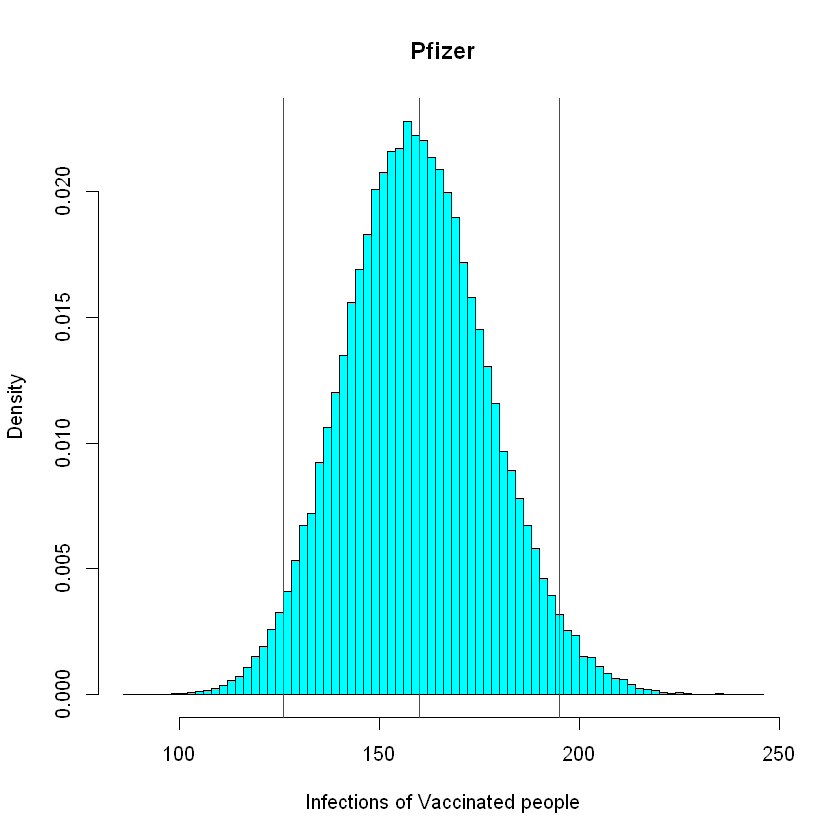

In [132]:
# Extract the efficacy samples from the chain
nva_samples <- chain.df.Pfizer$nV.A

# Calculate the 95% credibility interval using the quantile function
hdi <- hdi(nva_samples, credMass = 0.95)

# Print the HDI
cat("95% Interval of Confidence: [", hdi[1], ", ", hdi[2], "]\n")

cat(paste("mean: ", mean(chain.df.Pfizer$nV.A)))

hist(chain.df.Pfizer$nV.A, nc = 100, col = 'cyan', freq = FALSE,
     xlab = 'Infections of Vaccinated people', main = 'Pfizer')

horizontal <- c(hdi[1], mean(chain.df.Pfizer$nV.A), hdi[2])
abline(v = horizontal, col = "red")


In [133]:
#data for different age groups (pfizer study)
age_range<-c("<16", "16-55", "55-65", "65-75", ">75")
nP   <- c(331, 11533, 8208, 4226, 847)
nV   <- c(342, 11517, 8194, 4192, 842)
nP.I <- c(10, 568, 266, 124, 26)
nV.I <- c(0, 52, 25, 7, 1)

#data<- list(nP=nP[i], nV=nV[i], nP.I=nP.I[i], nV.I=nV.I[i])
#the data for a certain age_range is given by its index in age_range list

In [134]:
per_age_estimator<-function(i){
data<- list(nP=nP[i], nV=nV[i], nP.I=nP.I[i], nV.I=nV.I[i])
jm <- jags.model(modelinho, data)
update(jm, 100)
to.monitor <-  c('pA', 'eff', 'nV.A')
chain <- coda.samples(jm, to.monitor, n.iter=nr)
chain.df.Pfizer <- as.data.frame( as.mcmc(chain) )
eff_samples <- chain.df.Pfizer$eff
mean_eff <- mean(eff_samples)
return (mean_eff)
}



# Estimate vaccine efficacy for each age group
result <- vector()
for (i in seq_along(age_range)) {
  mean_eff <- per_age_estimator(i)
  result <- c(result, mean_eff)
}

# Print the estimated vaccine efficacy for each age group
for (i in seq_along(age_range)) {
  cat("Age Group:", age_range[i], "\tVaccine Efficacy:", round(result[i], 4), "\n")
}

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph 

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph 

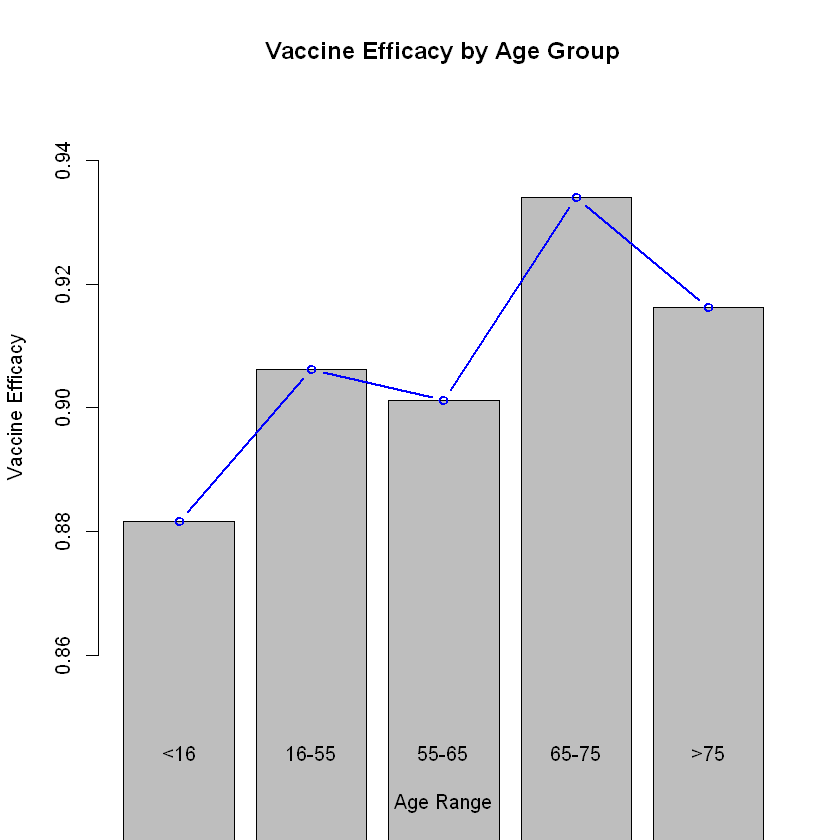

In [135]:
vaccine_efficacy <- vector()

for (i in seq_along(age_range)) {
  mean_eff <- per_age_estimator(i)
  vaccine_efficacy <- c(vaccine_efficacy, mean_eff)
}

# Create a barplot of vaccine efficacy by age range
barplot(vaccine_efficacy, names.arg = age_range, xlab = "Age Range",
        ylab = "Vaccine Efficacy", ylim = c(0.85, 0.95),
        main = "Vaccine Efficacy by Age Group")

# Calculate the x-coordinates of the center points
center_points <- barplot(vaccine_efficacy, plot = FALSE)

# Add a line graph representing the vaccine efficacy
lines(center_points, vaccine_efficacy, type = "b", col = "blue", lwd = 2)


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph 

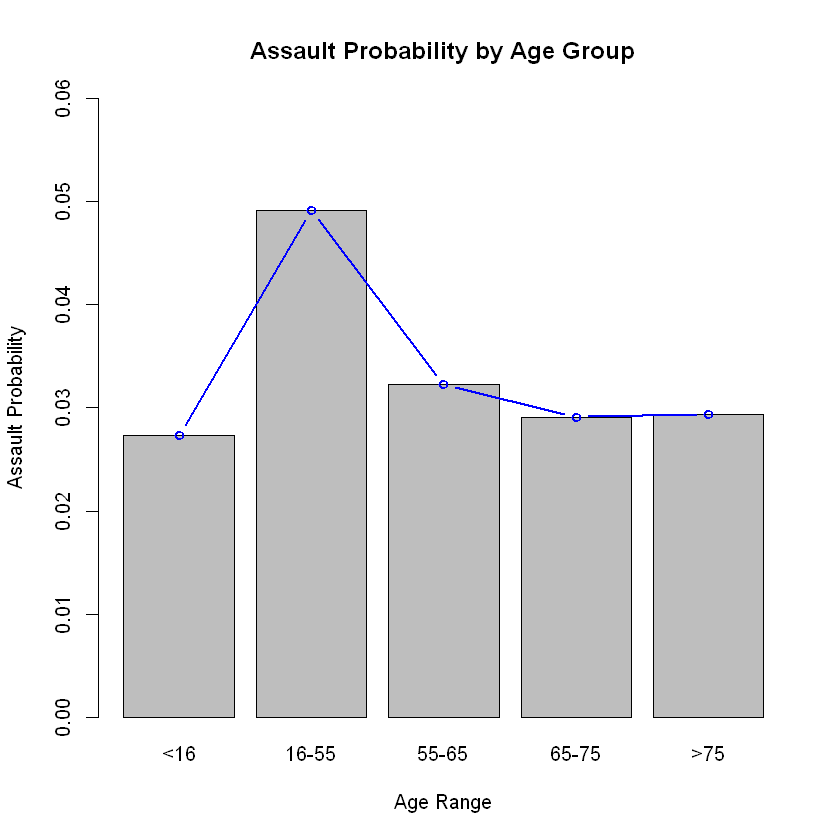

In [136]:
pA_per_age_estimator <- function(i) {
  data <- list(nP = nP[i], nV = nV[i], nP.I = nP.I[i], nV.I = nV.I[i])
  jm <- jags.model(modelinho, data)
  update(jm, 100)
  to.monitor <- c('pA', 'eff', 'nV.A')
  chain <- coda.samples(jm, to.monitor, n.iter = nr)
  chain.df.Pfizer <- as.data.frame(as.mcmc(chain))
  pA_samples <- chain.df.Pfizer$pA
  mean_pA <- mean(pA_samples)
  return(mean_pA)
}

# Estimate assault probability for each age group
result <- vector()
for (i in seq_along(age_range)) {
  mean_pA <- pA_per_age_estimator(i)
  result <- c(result, mean_pA)
}

# Print the estimated assault probability for each age group
for (i in seq_along(age_range)) {
  cat("Age Group:", age_range[i], "\tAssault Probability:", round(result[i], 4), "\n")
}

assault_probability <- result

# Create a barplot of assault probability by age range
barplot(assault_probability, names.arg = age_range, xlab = "Age Range",
        ylab = "Assault Probability", ylim = c(0, 0.06),
        main = "Assault Probability by Age Group")

# Calculate the x-coordinates of the center points
center_points <- barplot(assault_probability, plot = FALSE)

# Add a line graph representing the assault probability
lines(center_points, assault_probability, type = "b", col = "blue", lwd = 2)


# For janssen vaccine : 

In [150]:
# janssen Data
# Observed Data For the Model
nP   = 19691     # number of people in the placebo group
nV   = 19630     # number of people in the vaccine group
nP.I = 348       # number of people infected in the placebo group
nV.I = 116         # number of people infected in the vaccine group

data <- list(nP=nP, nV=nV, nP.I=nP.I, nV.I=nV.I)

jm <- jags.model(modelinho, data)     #feeding jags with the model and the data, jags model initializes
update(jm, 100)

to.monitor <-  c('pA', 'eff', 'nV.A') 
chai <- coda.samples(jm, to.monitor, n.iter=nr) 
autocorr.diag(chai)  
chai.df.janssen <- as.data.frame( as.mcmc(chai) ) 

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model



,eff,nV.A,pA
Lag 0,1.000000000,1.000000000,1.000000000
Lag 1,0.501701182,0.664788381,0.608237720
Lag 5,0.121584462,0.167451132,0.151404591
Lag 10,0.019791979,0.026429492,0.028448499
Lag 50,0.007115828,0.008932332,0.005955035


mean:  0.660819030667504[1] "\n"
95% Interval of Confidence: [ 0.58877354347448 ,  0.72913129364251 ]


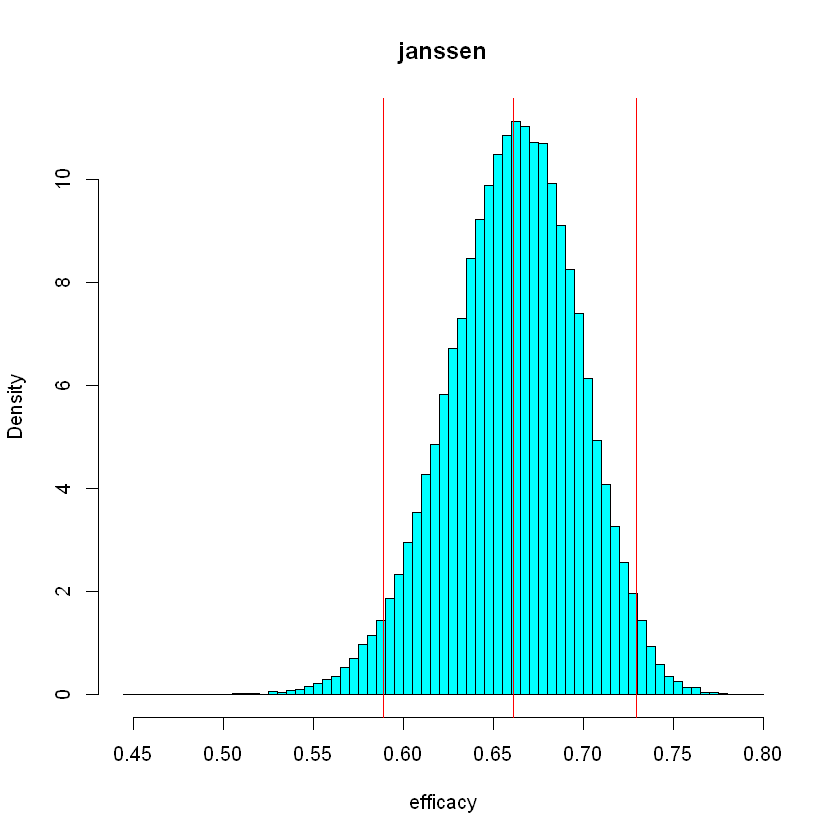

In [151]:
# Extract the efficacy samples from the chain
eff_samples <- chai.df.janssen$eff

# Calculate the 95% credibility interval using the HDI function
hdi <- hdi(eff_samples, credMass = 0.95)

cat(paste("mean: ", mean(chai.df.janssen$eff)))
print("\n")
cat(paste("95% Interval of Confidence: [", hdi[1], ", ", hdi[2], "]\n"))
hist(chai.df.janssen$eff, nc = 100, col = 'cyan', freq = FALSE,
     xlab = 'efficacy', main = 'janssen')

horizontal <- c(hdi[1], mean(chai.df.janssen$eff), hdi[2])
abline(v = horizontal, col = "red")


In [152]:
age_range<-c("<18", "18-65", "65-75")
#data for different age groups (janseen study)
nP   <- c(2490, 482, 98)
nV   <- c(2518, 477, 106)
nP.I <- c(170, 20,3)
nV.I <- c(60,6, 0)

per_age_estimator<-function(i){
data<- list(nP=nP[i], nV=nV[i], nP.I=nP.I[i], nV.I=nV.I[i])
jm <- jags.model(modelinho, data)
update(jm, 100)
to.monitor <-  c('pA', 'eff', 'nV.A')
chai <- coda.samples(jm, to.monitor, n.iter=nr)
chai.df.janssen<- as.data.frame( as.mcmc(chai) )
eff_samples <- chai.df.janssen$eff
mean_eff <- mean(eff_samples)
return (mean_eff)
}



# Estimate vaccine efficacy for each age group
result <- vector()
for (i in seq_along(age_range)) {
  mean_eff <- per_age_estimator(i)
  result <- c(result, mean_eff)
}

# Print the estimated vaccine efficacy for each age group
for (i in seq_along(age_range)) {
  cat("Age Group:", age_range[i], "\tVaccine Efficacy:", round(result[i], 4), "\n")
}

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Age Group: <18 	Vaccine Efficacy: 0.6414 
Age Group: 18-65 	Vaccine Efficacy: 0.6148 
Age Group: 65-75 	Vaccine Efficacy: 0.6781 


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model



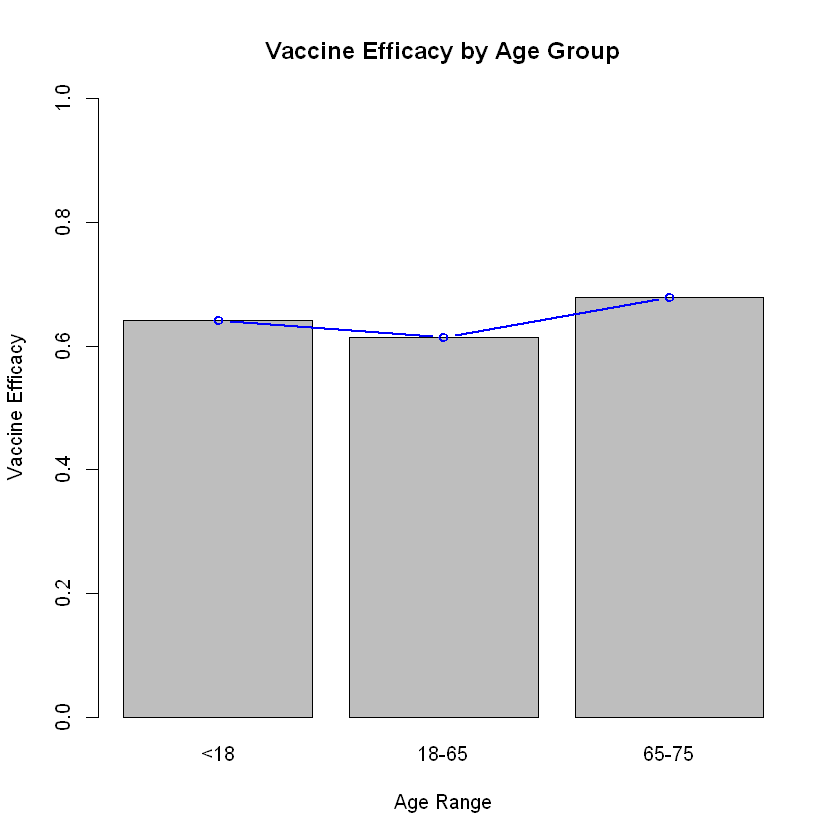

In [153]:
vaccine_efficacy <- vector()

for (i in seq_along(age_range)) {
  mean_eff <- per_age_estimator(i)
  vaccine_efficacy <- c(vaccine_efficacy, mean_eff)
}

# Create a barplot of vaccine efficacy by age range
barplot(vaccine_efficacy, names.arg = age_range, xlab = "Age Range",
        ylab = "Vaccine Efficacy", ylim = c(0,1),
        main = "Vaccine Efficacy by Age Group")

# Calculate the x-coordinates of the center points
center_points <- barplot(vaccine_efficacy, plot = FALSE)

# Add a line graph representing the vaccine efficacy
lines(center_points, vaccine_efficacy, type = "b", col = "blue", lwd = 2)


# For Moderna (spikevax) vaccine

In [154]:
# Observed Data For the Model
nP   = 14073     # number of people in the placebo group
nV   = 14134     # number of people in the vaccine group
nP.I = 185       # number of people infected in the placebo group
nV.I = 11         # number of people infected in the vaccine group
data <- list(nP=nP, nV=nV, nP.I=nP.I, nV.I=nV.I)
jm <- jags.model(modelinho, data)     #feeding jags with the model and the data, jags model initializes
update(jm, 100)
to.monitor <-  c('pA', 'eff', 'nV.A')      #telling it which variables we want to monitor
chaiin <- coda.samples(jm, to.monitor, n.iter=nr)   #output is a mcmc object
autocorr.diag(chaiin)  
chaiin.df.spikevax <- as.data.frame( as.mcmc(chaiin) )  

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model



,eff,nV.A,pA
Lag 0,1.000000000,1.000000000,1.000000000
Lag 1,0.124255815,0.530178255,0.615526892
Lag 5,0.015864071,0.081899739,0.100049723
Lag 10,0.001509444,0.001088190,0.003334150
Lag 50,-0.001118710,-0.001333344,-0.005794455


mean:  0.934810265178279
95% Interval of Confidence: [ 0.896507151767349 ,  0.970559838142221 ]


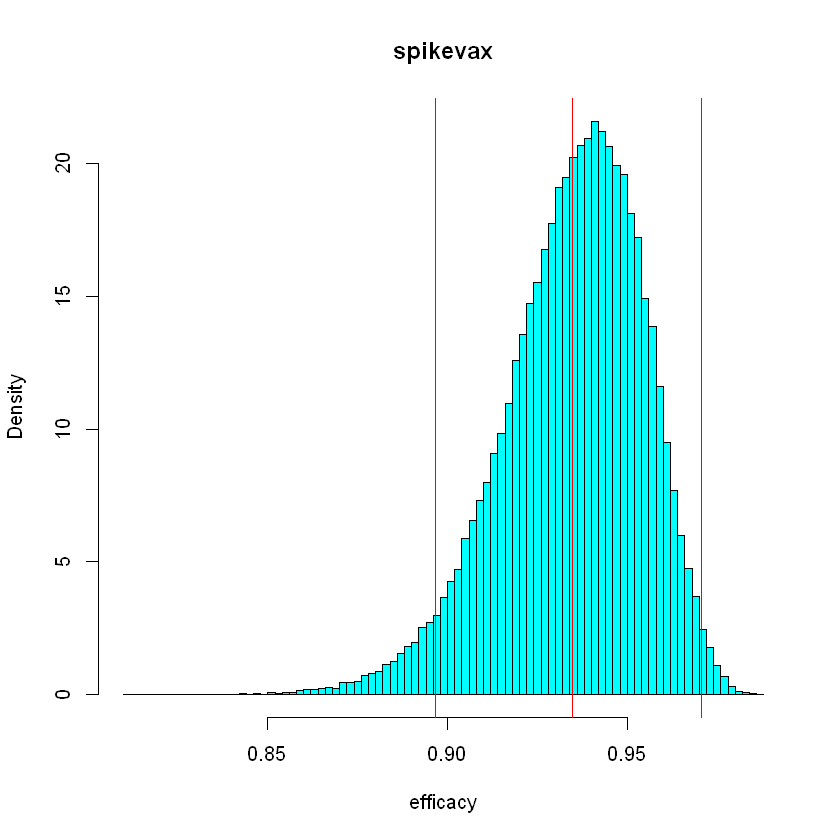

In [155]:
# Extract the efficacy samples from the chain
eff_samples <- chaiin.df.spikevax$eff

# Calculate the 95% credibility interval using the HDI function
hdi <- hdi(eff_samples, credMass = 0.95)

cat(paste("mean: ", mean(chaiin.df.spikevax $eff)))

cat(paste("\n"))

cat(paste("95% Interval of Confidence: [", hdi[1], ", ", hdi[2], "]\n"))

hist(chaiin.df.spikevax $eff, nc = 100, col = 'cyan', freq = FALSE,
     xlab = 'efficacy', main = 'spikevax')

horizontal <- c(hdi[1], mean(chaiin.df.spikevax $eff), hdi[2])
abline(v = horizontal, col = "red")


In [156]:
age_range<-c("<18", "16-65", "65-75")
nP   <- c(10521, 2864, 688)
nV   <- c(10551, 2953, 630)
nP.I <- c(156, 22, 7)
nV.I <- c(7,4,0)

In [157]:
per_age_estimator<-function(i){
data<- list(nP=nP[i], nV=nV[i], nP.I=nP.I[i], nV.I=nV.I[i])
j <- jags.model(modelinho, data)
update(jm, 100)
to.monitor <-  c('pA', 'eff', 'nV.A')
chaiin <- coda.samples(j, to.monitor, n.iter=nr)
chaiin.df.spikevax<- as.data.frame( as.mcmc(chaiin) )
eff_samples <- chaiin.df.spikevax$eff
mean_eff <- mean(eff_samples)
return (mean_eff)
}



# Estimate vaccine efficacy for each age group
result <- vector()
for (i in seq_along(age_range)) {
  mean_eff <- per_age_estimator(i)
  result <- c(result, mean_eff)
}

# Print the estimated vaccine efficacy for each age group
for (i in seq_along(age_range)) {
  cat("Age Group:", age_range[i], "\tVaccine Efficacy:", round(result[i], 4), "\n")
}

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Age Group: <18 	Vaccine Efficacy: 0.9483 
Age Group: 16-65 	Vaccine Efficacy: 0.7582 
Age Group: 65-75 	Vaccine Efficacy: 0.8072 


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model



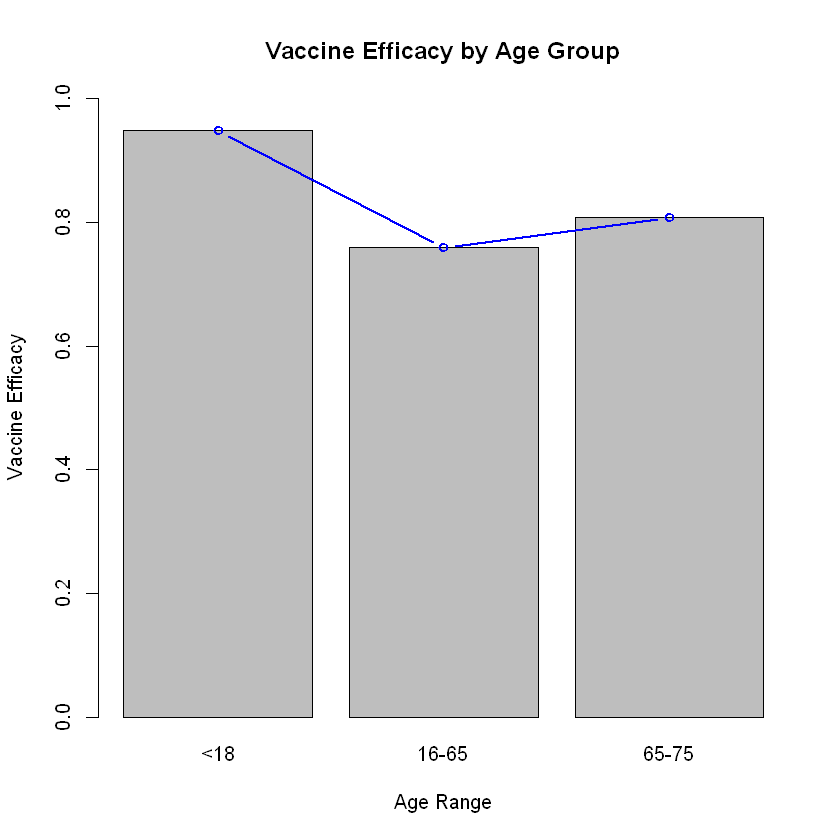

In [158]:
vaccine_efficacy <- vector()

for (i in seq_along(age_range)) {
  mean_eff <- per_age_estimator(i)
  vaccine_efficacy <- c(vaccine_efficacy, mean_eff)
}

# Create a barplot of vaccine efficacy by age range
barplot(vaccine_efficacy, names.arg = age_range, xlab = "Age Range",
        ylab = "Vaccine Efficacy", ylim = c(0, 1),
        main = "Vaccine Efficacy by Age Group")
# Calculate the x-coordinates of the center points
center_points <- barplot(vaccine_efficacy, plot = FALSE)

# Add a line graph representing the vaccine efficacy
lines(center_points, vaccine_efficacy, type = "b", col = "blue", lwd = 2)


## For nuvaxovid vaccine

In [146]:
nP   = 8140     # number of people in the placebo group
nV   = 17312     # number of people in the vaccine group
nP.I = 63       # number of people infected in the placebo group
nV.I = 14         # number of people infected in the vaccine group

data <- list(nP=nP, nV=nV, nP.I=nP.I, nV.I=nV.I)

jm <- jags.model(modelinho, data)     #feeding jags with the model and the data, jags model initializes
update(jm, 100)
to.monitor <-  c('pA', 'eff', 'nV.A')      #telling it which variables we want to monitor
chaiinn <- coda.samples(jm, to.monitor, n.iter=nr)   #output is a mcmc object
autocorr.diag(chaiinn)  
chaiinn.df.nuvaxovid <- as.data.frame( as.mcmc(chaiinn) )  

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model



,eff,nV.A,pA
Lag 0,1.000000000,1.00000000,1.000000000
Lag 1,0.291783489,0.71692810,0.761967403
Lag 5,0.097852708,0.27339177,0.291216896
Lag 10,0.022947555,0.07457823,0.079334925
Lag 50,0.002990398,0.00596321,0.003721556


mean:  0.884651257259898
95% Interval of Confidence: [ 0.81701383159227 ,  0.94385170168681 ]


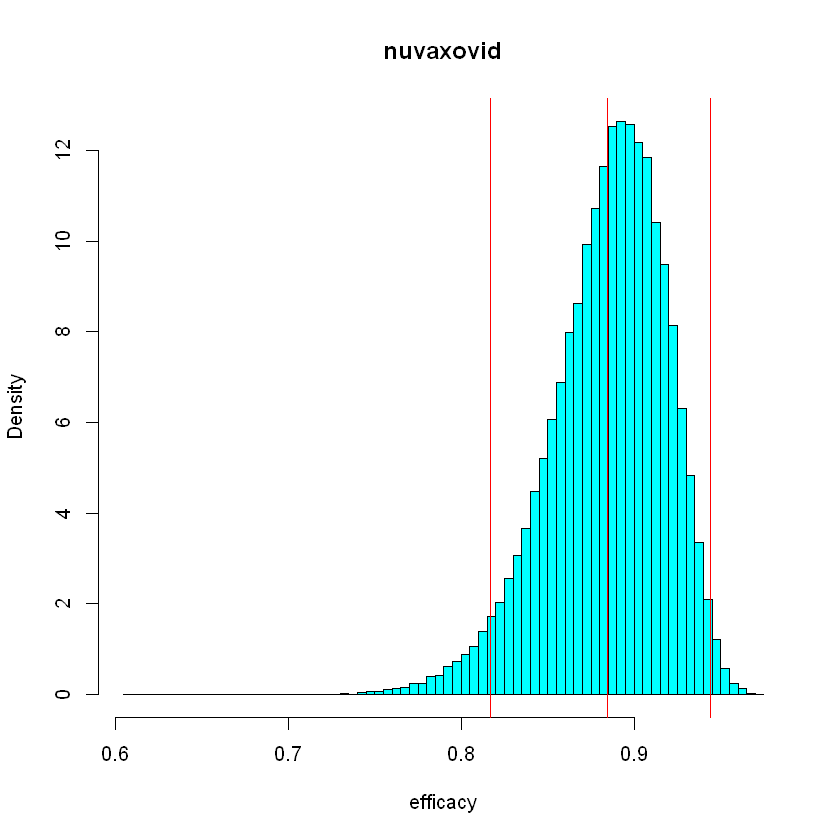

In [147]:
# Extract the efficacy samples from the chain
eff_samples <- chaiinn.df.nuvaxovid$eff

# Calculate the 95% credibility interval using the HDI function
hdi <- hdi(eff_samples, credMass = 0.95)

cat(paste("mean: ", mean(chaiinn.df.nuvaxovid $eff)))

cat(paste("\n"))

cat(paste("95% Interval of Confidence: [", hdi[1], ", ", hdi[2], "]\n"))

hist(chaiinn.df.nuvaxovid $eff, nc = 100, col = 'cyan', freq = FALSE,
     xlab = 'efficacy', main = 'nuvaxovid')

horizontal <- c(hdi[1], mean(chaiinn.df.nuvaxovid $eff), hdi[2])
abline(v = horizontal, col = "red")


## For vaxzevria vaccine

In [148]:
nP   = 8550     # number of people in the placebo group
nV   = 17312     # number of people in the vaccine group
nP.I = 130       # number of people infected in the placebo group
nV.I = 73         # number of people infected in the vaccine group

data <- list(nP=nP, nV=nV, nP.I=nP.I, nV.I=nV.I)

jm <- jags.model(modelinho, data)     #feeding jags with the model and the data, jags model initializes
update(jm, 100)
to.monitor <-  c('pA', 'eff', 'nV.A')      #telling it which variables we want to monitor
chaiiinn <- coda.samples(jm, to.monitor, n.iter=nr)   #output is a mcmc object
autocorr.diag(chaiiinn)  
chaiiinn.df.vaxzevria <- as.data.frame( as.mcmc(chaiiinn) )  

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2
   Unobserved stochastic nodes: 3
   Total graph size: 10

Initializing model



,eff,nV.A,pA
Lag 0,1.000000000,1.000000000,1.00000000
Lag 1,0.539287282,0.758512211,0.73901040
Lag 5,0.207706478,0.307251407,0.29705840
Lag 10,0.060593103,0.093865370,0.09221868
Lag 50,-0.003933943,-0.004245401,-0.00360419


mean:  0.714557567609463
95% Interval of Confidence: [ 0.630520230345842 ,  0.790586174118812 ]


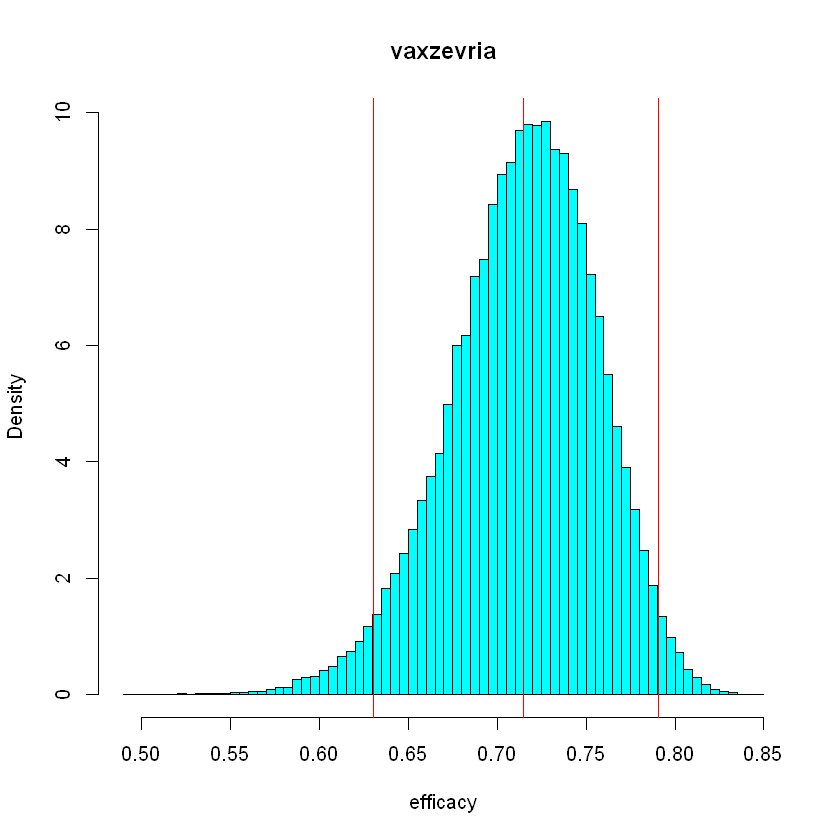

In [149]:
# Extract the efficacy samples from the chain
eff_samples <- chaiiinn.df.vaxzevria$eff

# Calculate the 95% credibility interval using the HDI function
hdi <- hdi(eff_samples, credMass = 0.95)

cat(paste("mean: ", mean(chaiiinn.df.vaxzevria $eff)))

cat(paste("\n"))

cat(paste("95% Interval of Confidence: [", hdi[1], ", ", hdi[2], "]\n"))

hist(chaiiinn.df.vaxzevria $eff, nc = 100, col = 'cyan', freq = FALSE,
     xlab = 'efficacy', main = 'vaxzevria')

horizontal <- c(hdi[1], mean(chaiiinn.df.vaxzevria $eff), hdi[2])
abline(v = horizontal, col = "red")
